# Neural-network analysis of XANES data  for Platinum nanoparticles

This tutorial was originally written by Janis Timoshenko and translated to Python, modified by Ryuichi Shimogawa.

Reference:
Timoshenko et al, *J. Phys. Chem. Lett.* **2017**, *8*, 5091-5098

# Table of Contents

Each notebook contains a detailed description of the code.
The all in one code is in [04_NN_XANES_All_in_one_code.ipynb](./04_NN_XANES_All_in_one_code.ipynb).

0. [Introduction](./00_NN_XANES_Introduction.ipynb)
2. [Training data preparation (Structure generation and FEFF and FDMNES calculation)](./01_NN_XANES_Training_data_preparation.ipynb)
3. [Loading theoretical data and augmentation](./02_NN_XANES_Loading_data.ipynb)
4. [Creating, training, and evaluation of a neural network](./03_NN_XANES_Neural_network.ipynb)
5. [All-in-one code](./04_NN_XANES_All_in_one_code.ipynb)


# [Loading theoretical data and augmentation](./02_NN_XANES_Loading_data.ipynb)

In this notebook, we will describe how to load the theoretical XANES spectra and how to augment the data set.

## General procedure

1. Reading a FEFF input file.
    - Reading xyz coodrdinates: For the current Current training data, xyz data are contained in the `feff.inp` file.
    - Reading Absorbing atom: The absorbing atom is defined as `0` in the `POTENTIALS` in the `feff.inp` file.
    (Coordination and the bond )
2. Reading a FEFF output file.
    - Reading absoption coefficient: The absorption coefficient is contained in the `xmu.dat` file.
    First column is the energy and the fourth column is the absorption coefficient.
3. Reading a FDMNES output file.
    - Reading the weight of the absorption coefficient: In FDMNES calculation, the multiplicity of the absorbing atom and the symmetry is calculated prior to the XANES calculation. The output of the each individual calculation is already weighted by the multiplicity and therefore required to be devided by the multiplicity, in order to obtain the single contribution of the absorbing atom.
    - Reading absoption coefficient: The absorption coefficient is contained in the `out_fdmnes_conv.txt` file.
4. Interpolation of the theoretical spectra.
    - Finding a common energy grid: The energy grid of the theoretical spectra are different from each other. Therefore, we need to find a common energy grid for all the spectra.
    - Interpolation: The theoretical spectra are interpolated to the common energy grid.
5. Coordination number calculation.
    - Coordination number calculation: The coordination number is calculated by generating a distance matrix and counting the number of atoms within the given range of radius.

# Downloading the data

The data required for the tutorial can be download and unzip the data by following commands.

In [3]:
!gdown https://drive.google.com/u/1/uc?id=1YXIm31N7DnV8UHJbgTB7vj9Qq5la5-Zd&export=download

In [4]:
!unzip IV_Machine_learning_demo.zip

Archive:  IV_Machine_learning_demo.zip
replace IV_Machine_learning_demo/machine_learning.nb? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# 0. Installation of dependencies

Before running this notebook, you need to install the following packages.

Press "Shift+Enter" to run the cell.


In [5]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Password:
sudo: a password is required


In [6]:
pip install scienceplots py3Dmol lightning pydantic

Note: you may need to restart the kernel to use updated packages.


## Importing required modules and loading utility functions

Some modules are required to run this notebook. The following cell imports the modules and loads the utility functions. Some modules will be imported later on for clarity.

Press "Shift+Enter" to run the cell.

In [2]:
# Standard libraries
import os
import re

# Libraries related to data manupulation
import pandas as pd
import numpy as np

In [43]:
# Libraries related to plotting
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.ticker as ticker

plt.style.use(['science','nature', "bright"])
font_size = 8
plt.rcParams.update({'font.size': font_size})
plt.rcParams.update({'axes.labelsize': font_size})
plt.rcParams.update({'xtick.labelsize': font_size})
plt.rcParams.update({'ytick.labelsize': font_size})
plt.rcParams.update({'legend.fontsize': font_size})

## Ploting utility functions

In [44]:
def plot_XANES(spectra, labels, E0 = 11563, E_range = None):

    if E_range is None:
        E_range = [E0 -20, E0 + 80]


    fig, ax = plt.subplots(figsize=(3,3))

    # set enegy range for E
    E0 = 11563
    E_range = [E0 -20, E0 + 80]


    for i in range(len(spectra)):
        ax.plot(spectra[i][:, 0], spectra[i][:, 1], label=labels[i])

    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Normalized absorption")

    ax.set_xlim(E_range)

    ax.legend()

    fig.tight_layout(pad=0.5)

    fig.show()


In [45]:
def plot_spectra_and_CN(spectra_and_CN, index_list, E0 = 11563, E_range = None):

    E0 = 11563
    if E_range is None:
        E_range = [E0 -20, E0 + 80]

    fig, ax = plt.subplots(len(index_list), 2, figsize=(6, 3*(len(index_list))))
    ax = ax.flatten()

    for i in range(len(index_list)):
        fig.text(0, 1-i/len(index_list), f"Spectrum {index_list[i]}")

        ax[i*2 + 0].plot(spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1], label="FDMNES")
        ax[i*2 + 1].plot(spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1], label="FEFF")
        ax[i*2 + 0].plot(foilexperiment[:, 0], foilexperiment[:, 1], label="Pt Foil (Exp)")
        ax[i*2 + 1].plot(foilexperiment[:, 0], foilexperiment[:, 1], label="Pt Foil (Exp)")

        y_max = max(spectra_and_CN[i][0][:, 1].max(), spectra_and_CN[i][1][:, 1].max())

        for j in range(2):
            ax[i*2 + j].set_xlabel("Energy (eV)")
            ax[i*2 + j].set_ylabel("Normalized absorption")
            ax[i*2 + j].set_ylim(0, y_max*1.1)
            ax[i*2 + j].set_xlim(E_range)
            ax[i*2 + j].legend()


    fig.tight_layout(h_pad=1.5, w_pad=0.5)
    fig.show()

In [46]:
import py3Dmol

def plot_molecule(file_xyz):
    with open(file_xyz, "r") as f:
        xyz = f.read()

    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz, "xyz")
    view.setStyle({'sphere':{'scale': 0.4}, 'stick':{'scale': 0.2}})
    # view.setStyle({'sphere':{'scale': 0.4}})
    view.zoomTo()
    return view

def plot_spectra_and_CN_model(spectra_and_CN, index_list):
    for index in index_list:
        print("Spectrum ID:", index)
        print("Coordination numbers:", spectra_and_CN[index][2])
        print("File path:", spectra_and_CN[index][3])
        plot_molecule(spectra_and_CN[index][3]).show()

In [47]:
def plot_spectra_and_CN_stack(spectra_and_CN, index_list, E0 = 11563, E_range = None):

    E0 = 11563
    if E_range is None:
        E_range = [E0 -20, E0 + 80]

    fig, ax = plt.subplots(len(index_list), 1, figsize=(3, 3*(len(index_list))))
    ax = ax.flatten()

    for i in range(len(index_list)):
        fig.text(0, 1-i/len(index_list), f"Spectrum {index_list[i]}")

        ax[i].plot(spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1], label="FDMNES")
        ax[i].plot(spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1], label="FEFF")

        y_max = max(spectra_and_CN[i][0][:, 1].max(), spectra_and_CN[i][1][:, 1].max())

        ax[i].set_xlabel("Energy (eV)")
        ax[i].set_ylabel("Normalized absorption")
        ax[i].set_ylim(0, y_max*1.1)
        ax[i].set_xlim(E_range)
        ax[i].legend()

    fig.tight_layout(h_pad=1.5, w_pad=0.5)
    fig.show()

## Definining Constants

Scaling factor and energy shift for the FDMNES calculations were calculated prior to the modeling, and the values are defined here.

In [57]:
# Directory that contains the data

dir_path = "IV_Machine_learning_demo/NN-XANES-data/nanoparticles/"

In [58]:
# CONSTANTS: FDMNES energy shift and scale factors

fdmnes_scale_factors = 0.036
fdmnes_energy_shift = 11563

In [59]:
# FEFF keywords used for parsing

feff_keywords = [
    "ATOMS", "POTENTIALS", "RECIPROCAL", "REAL", "CIF", "LATTICE",
    "TARGET", "TITLE", "COORDINATES", "RMULTIPLIER", "SGROUP",
    "CFAVERAGE", "OVERLAP", "EQUIVALENCE", "EXAFS", "ELNES",
    "EXELFS", "LDOS", "XANES", "ELLIPTICITY", "MULTIPOLE",
    "POLARIZATION", "COMPTON", "DANES", "FPRIME", "MDFF",
    "NRIXS", "XES", "XNCD", "CONTROL", "END", "KMESH", "PRINT",
    "DIMS", "EGRID", "AFOLP", "COREHOLE", "EDGE", "SCF", "S02",
    "CHBROAD", "CONFIG", "EXCHANGE", "FOLP", "HOLE", "NOHOLE",
    "RGRID", "UNFREEZEF", "CHSHIFT", "CHWIDTH", "CORVAL", "EGAP",
    "EPS0", "EXTPOT", "INTERSTITIAL", "ION", "JUMPRM", "NUMDENS",
    "OPCONS", "PREP", "RESTART", "SCREEN", "SETE", "SPIN", "LJMAX",
    "LDEC", "MPSE", "PLASMON", "PMBSE", "RPHASES", "RSIGMA", "TDLDA",
    "FMS", "DEBYE", "BANDSTRUCTURE", "STRFACTORS", "RPATH", "NLEG",
    "PCRITERIA", "SS", "SYMMETRY", "CRITERIA", "IORDER", "NSTAR",
    "ABSOLUTE", "CORRECTIONS", "SIG2", "SIG3", "SIGGK", "MBCONV",
    "SFCONV", "RCONV", "SELF", "SFSE", "CGRID", "RHOZZP", "MAGIC",
]


## Reading a FEFF input file.

- Reading xyz coodrdinates: For the current Current training data, xyz data are contained in the `feff.inp` file.
    - We use regular expression to extract the xyz coodrinates that are contained in the ATOMS card. The full keyword list is defined prior to devide in to sections.
- Reading Absorbing atom: The absorbing atom is defined as `0` in the `POTENTIALS` in the `feff.inp` file.
    - The absorbing atom can be find by searching for the `0` in the forth column of the `ATOMS` card.

In [60]:
def read_xyz_from_feff(feff_input: str) -> tuple[int, np.ndarray]:
    """Reads the coordinates from a FEFF input string

    Args:
        feff_input (str): FEFF input string

    Returns:
        absorb_index (int): Index of the absorbing atom
        coordinates (np.ndarray): Coordinates of the atoms
    """

    feff_keywords_pattern = "|".join(feff_keywords)
    comment_pattern = re.compile(r"\*.*\n")
    ATOMS_pattern = re.compile(r"ATOMS\n(.*)\n(?:{})".format(feff_keywords_pattern), re.DOTALL)

    text_without_comments = re.sub(comment_pattern, '', feff_input)
    atoms_text = re.findall(ATOMS_pattern, text_without_comments)[0]
    atoms_text = atoms_text.split("\n")

    coordinates = []
    absorb_index = 0

    for line in atoms_text:
        position = line.split()

        if len(position) > 3:
            coordinates.append(position[:3])

            if position[3] == "0":
                absorb_index = len(coordinates) - 1

    return absorb_index, np.array(coordinates, dtype=float)

def read_xyz_from_feff_file(filename: str) -> tuple[int, np.ndarray]:
    """Reads the coordinates from a FEFF input file

    Args:
        filename (str): FEFF input file path

    Returns:
        absorb_index (int): Index of the absorbing atom
        coordinates (np.ndarray): Coordinates of the atoms
    """

    if not os.path.isfile(filename):
        raise FileNotFoundError("File {} not found".format(filename))

    with open(filename, "r") as f:
        feff_input = f.read()

    return read_xyz_from_feff(feff_input)

In [61]:
# Testing the function

test_feff_input_file = "./COC013/1/feff.inp"

absorb_index, coordinates = read_xyz_from_feff_file(os.path.join(dir_path, test_feff_input_file))

print("Absorbing atom index: {}".format(absorb_index))
print("Coordinates of the atoms:\n{}".format(coordinates))

Absorbing atom index: 0
Coordinates of the atoms:
[[ 0.      0.      0.    ]
 [ 0.      1.9621  1.9621]
 [ 1.9621  0.      1.9621]
 [ 1.9621  1.9621  0.    ]
 [ 0.      1.9621 -1.9621]
 [ 1.9621  0.     -1.9621]
 [ 0.     -1.9621  1.9621]
 [ 1.9621 -1.9621  0.    ]
 [ 0.     -1.9621 -1.9621]
 [-1.9621  0.      1.9621]
 [-1.9621  1.9621  0.    ]
 [-1.9621  0.     -1.9621]
 [-1.9621 -1.9621  0.    ]]


2. Reading a FEFF output file.
    - Reading absoption coefficient: The absorption coefficient is contained in the `xmu.dat` file.
    First column is the energy and the fourth column is the absorption coefficient.

In [62]:
def get_XAS_feff(filename: str) -> np.ndarray:
    """Reads the XAS data from a FEFF output file

    Args:
        filename (str): FEFF output file path

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """
    feff_data = np.loadtxt(filename, skiprows=1)
    return feff_data[:, [0,3]]

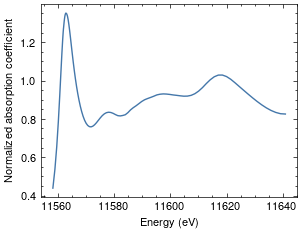

In [63]:
# Testing the function
test_feff_output_file = "./COC013/1/xmu.dat"

FEFF_spectrum = get_XAS_feff(os.path.join(dir_path, test_feff_output_file))

plt.plot(FEFF_spectrum[:,0], FEFF_spectrum[:,1])
plt.xlabel("Energy (eV)")
plt.ylabel("Normalized absorption coefficient")
plt.show()

3. Reading a FDMNES output file.
    - Reading the weight of the absorption coefficient: In FDMNES calculation, the multiplicity of the absorbing atom and the symmetry is calculated prior to the XANES calculation. The output of the each individual calculation is already weighted by the multiplicity and therefore required to be devided by the multiplicity, in order to obtain the single contribution of the absorbing atom.
    - Reading absoption coefficient: The absorption coefficient is contained in the `out_fdmnes_conv.txt` file.

In [68]:
def w(filename: str,n: int) -> float:
    """Obtain weight from the fdmnes output file

    Args:
        filename (str): FDMNES output file path
        n (int): Index of site

    Returns:
        weight (float): Multiplicity of the site
    """

    # n=0
    with open(filename,'r') as f:
        text = f.readlines()

    for line in text:
        if line.startswith("ipr"):
            if n == 0:
                return float(line.split()[-1])

            n-=1
            
def get_XAS_fdmnes(filename: str, w: [int, float] = 1) -> np.ndarray:
    """Reads the XAS data from a FDMNES output file

    Args:
        filename (str): FDMNES output file path
        w (int, optional): Weight of the XAS spectrum. Defaults to 1.

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """

    fdmnes_data = np.loadtxt(filename, skiprows=1)
    
    fdmnes_data[:, 0] += fdmnes_energy_shift
    fdmnes_data[:, 1] /= fdmnes_scale_factors*w
    return fdmnes_data

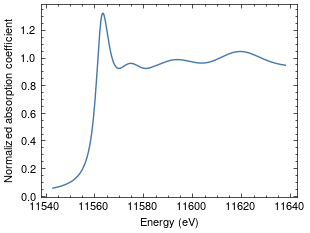

In [69]:
# Testing the function

test_fdmnes_output_bav_file = "./COC013/1/out_fdmnes_bav.txt"
test_fdmnes_output_conv_file = "./COC013/1/out_fdmnes_conv.txt"

weight = w(os.path.join(dir_path, test_fdmnes_output_bav_file), 0)
fdmnes_spectrum = get_XAS_fdmnes(os.path.join(dir_path, test_fdmnes_output_conv_file), weight)


plt.plot(fdmnes_spectrum[:,0], fdmnes_spectrum[:,1])
plt.xlabel("Energy (eV)")
plt.ylabel("Normalized absorption coefficient")
plt.show()

4-1. Reading experimental data
    - Reading experimental data: The experimental data is contained in the `exp_xanes.nor` file.
    - The eshift is precalculated to match with the spectra.

4-2. Reading Foil data
    - The theoretical calculation of the foil is done prior to the theoretical calculation of the nanoparticles to 1) obtain the hyperparameters for the theoretical calculation and 2) to obtain the reference spectra.
    - The data is located in the `feff_for_Pt_bulk.dat` and `fdmnes_for_Pt_bulk_conv.txt` files.

In [70]:
def get_XAS_experiment(filename: str, i: int, dele: float = 0.0) -> np.ndarray:
    """Reads the XAS data from an experimental file

    Args:
        filename (str): Experimental file path
        i (int): Column index of the absorption coefficients
        dele (float, optional): Energy shift. Defaults to 0.0. The energy will be calculated as energy = energy - dele.

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """
    experiment_data = np.loadtxt(filename, skiprows=1)
    experiment_data[:,0] -= dele
    return experiment_data[:, [0, i]]

In [71]:
# Testing the function

data_dir = "IV_Machine_learning_demo/NN-XANES-data/"
sample_dir = ""
feff_file = "feff_for_Pt_bulk.dat"
fdmnes_file = "fdmnes_for_Pt_bulk_conv.txt"
experimnet_file = "exp_xanes.nor"

foilFEFF = get_XAS_feff(os.path.join(data_dir, sample_dir, feff_file))
foilFDMNES = get_XAS_fdmnes(os.path.join(data_dir, sample_dir, fdmnes_file), 4)
foilexperiment = get_XAS_experiment(os.path.join(data_dir, sample_dir, experimnet_file), 1, 3)

/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/1192666718.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


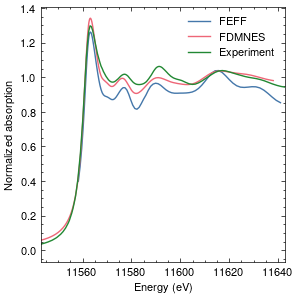

In [72]:
plot_XANES([foilFEFF, foilFDMNES, foilexperiment], ["FEFF", "FDMNES", "Experiment"])

5. Coordination number calculation.
    - Coordination number calculation: The coordination number is calculated by generating a distance matrix and counting the number of atoms within the given range of radius.

In [73]:
from scipy.spatial import distance

NN_RANGE = [
    [0, 3.5],
    [3.5, 4.4],
    [4.4, 5.2],
    [5.2, 6.0],
]

# some efficient ways to calculate distance matrix
def dist_matrix(xyz: np.ndarray, absorb_index: int = None)->np.ndarray:
    """Calculate the distance matrix of the atoms

    Args:
        xyz (np.ndarray): Coordinates of the atoms
        absorb_index (int, optional): Index of the absorbing atom. Defaults to None.

    Returns:
        np.ndarray: Distance matrix of xyz coordinates. If absorb_index is None, the shape of the matrix is (N, N), where N is the number of atoms. If absorb_index is not None, the shape of the matrix is (1, N).
    """
    if absorb_index is None:
        return distance.cdist(xyz, xyz, "euclidean")
        # d = xyz[:,None,:]-xyz
        # return np.sqrt(np.einsum('ijk,ijk->ij',d,d))
    else:
        return distance.cdist(xyz[[absorb_index]], xyz, "euclidean")
        # d = xyz[absorb_index] - xyz
        # return np.sqrt(np.einsum('ij,ij->i',d,d))

def get_NN_from_xyz(xyz: np.ndarray, absorb_index:int = None, NN_range: list[list] = None):
    """Calculate the nearest neighbor distribution of the atoms

    Args:
        xyz (np.ndarray): Coordinates of the atoms
        absorb_index (int, optional): Index of the absorbing atom. Defaults to None.
        NN_range (list[list], optional): Range of the nearest neighbor distribution. Defaults to None.

    Returns:
        np.ndarray: Nearest neighbor distribution of the atoms. If absorb_index in None, particle average NN is returned. If absorb_index is not None, site specific NN is returned.
    """
    if NN_range is None:
        NN_range = NN_RANGE

    dist_mat = dist_matrix(xyz, absorb_index)

    if absorb_index is not None:
        atom_num = 1
    else:
        atom_num = len(xyz)

    NN = []

    for i in range(len(NN_range)):
        NN_tmp = dist_mat[(dist_mat > NN_range[i][0]) & (dist_mat <= NN_range[i][1])]
        NN.append(len(NN_tmp)/atom_num)

    return np.array(NN)

In [74]:
# Test obtaining Nearest Neighbors from the xyz file
xyz = np.array([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4],[0,0,5]])
print("NN around atom 0:",get_NN_from_xyz(xyz, 0))
print("Average NN:", get_NN_from_xyz(xyz))

NN around atom 0: [3. 1. 1. 0.]
Average NN: [4.         0.66666667 0.33333333 0.        ]


- Reading a FEFF input, output, and FDMNES input file, and return to list

In [75]:
from glob import glob

def obtain_spectra_and_CN_single_site(dir_path: str, n: int = 0):
    """Obtain XAS spectra, coordination number and coordinates from a directory

    Args:
        dir_path (str): Directory path
        n (int, optional): Index of site. Defaults to 0.

    Returns:
        [fdmnes_data, feff_data, CN, file_xyz]: [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]
    """
    file_xyz = glob(os.path.join(dir_path, "*.xyz"))[0]
    feff_inp = os.path.join(dir_path, "feff.inp")
    feff_out = os.path.join(dir_path, "xmu.dat")
    fdmnes_file = os.path.join(dir_path, "out_fdmnes_conv.txt")
    fdmnes_bav_file = os.path.join(dir_path, "out_fdmnes_bav.txt")
    absorb_index, positions = read_xyz_from_feff_file(feff_inp)
    weight = w(fdmnes_bav_file, n)
    fdmnes_data = get_XAS_fdmnes(fdmnes_file, weight)
    feff_data = get_XAS_feff(feff_out)
    CN = get_NN_from_xyz(positions, absorb_index)
    return [fdmnes_data, feff_data, CN, file_xyz]

def obtain_spectra_and_CN(dir_path):
    """Obtain XAS spectra, coordination number and coordinates from a directory

    Args:
        dir_path (str): Directory path

    Returns:
        spectra_and_CN (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]
    """
    particle_name_pattern = re.compile(r'.*/(.+)/(.*)/')

    dir_list = glob(os.path.join(dir_path, "*/*/"))

    spectra_and_CN = []

    for directory in dir_list:
        particle_regex = re.findall(particle_name_pattern, directory)[0]
        particle = particle_regex[0]
        site = particle_regex[1]

        directory = os.path.join(dir_path, particle, site)

        spectra_and_CN.append(obtain_spectra_and_CN_single_site(directory, int(site) - 1))

    return spectra_and_CN

In [76]:
spectra_and_CN = obtain_spectra_and_CN(dir_path)

## Plot some random model and spectra

Spectrum ID: 200
Coordination numbers: [5. 2. 6. 5.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCN055/06/Pt55.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Spectrum ID: 122
Coordination numbers: [7. 3. 8. 5.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCP057/18/Pt57.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Spectrum ID: 154
Coordination numbers: [7. 3. 6. 2.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCN076/03/Pt76.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/3861879925.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


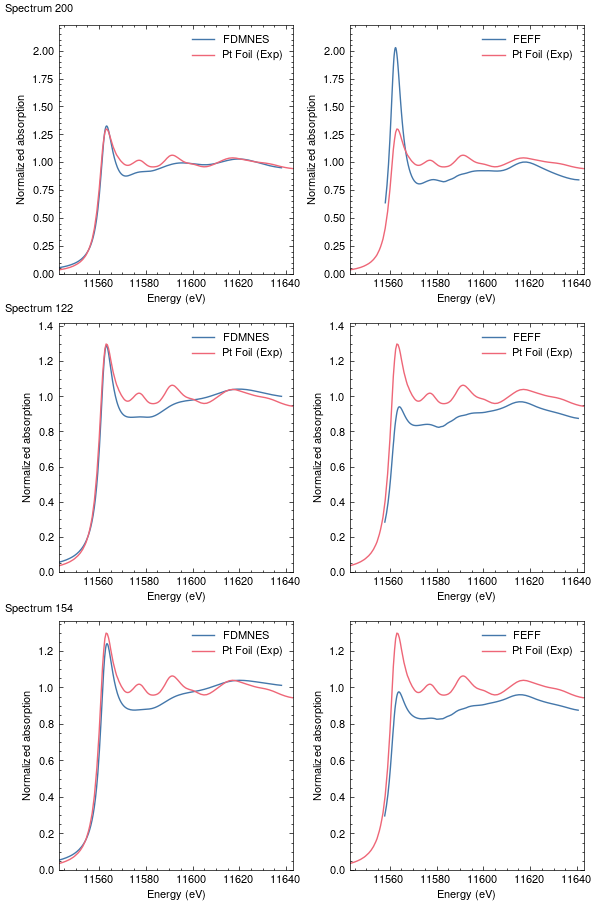

In [77]:
index_list = np.random.randint(0, len(spectra_and_CN), 3)

plot_spectra_and_CN_model(spectra_and_CN, index_list)
plot_spectra_and_CN(spectra_and_CN, index_list)

4. Interpolation of the theoretical spectra.
    - Finding a common energy grid: The energy grid of the theoretical spectra are different from each other. Therefore, we need to find a common energy grid for all the spectra.
    - Interpolation: The theoretical spectra are interpolated to the common energy grid.

In [78]:
min_feff = np.min([spectra_and_CN[i][1][0][0] for i in range(len(spectra_and_CN))])
max_feff = np.min([spectra_and_CN[i][1][-1][0] for i in range(len(spectra_and_CN))])
min_fdmnes = np.max([spectra_and_CN[i][0][0][0] for i in range(len(spectra_and_CN))])
max_fdmnes = np.max([spectra_and_CN[i][0][-1][0] for i in range(len(spectra_and_CN))])

print(f"Energy range of FEFF: {min_feff} - {max_feff}")
print(f"Energy range of FDMNES: {min_fdmnes} - {max_fdmnes}")

Energy range of FEFF: 11557.844 - 11640.53
Energy range of FDMNES: 11543.0 - 11638.0


Finding a common energy grid. (Custom energy grid can also be used.)
- Finding a common energy grid: The energy grid of the theoretical spectra are different from each other. Therefore, we need to find a common energy grid for all the spectra.
- Interpolation: The theoretical spectra are interpolated to the common energy grid.


In [80]:
# caculate the energy range of the spectra, which contains all the spectra
emin = np.max([min_feff, min_fdmnes, foilFDMNES[0][0], foilFEFF[0][0]])
emax = np.min([max_feff, max_fdmnes, foilFDMNES[-1][0], foilFEFF[-1][0]])
emesharray = spectra_and_CN[0][0][:, 0]
emesh = emesharray[np.logical_and(emesharray<=emax, emesharray>=emin)]

/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/1192666718.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


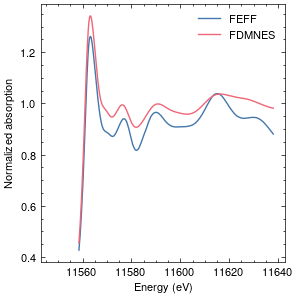

In [81]:
# interpolate the spectra to the same energy mesh (emesh)
foilFEFFi = np.interp(emesh, foilFEFF[:, 0], foilFEFF[:, 1])
foilFDMNESi = np.interp(emesh, foilFDMNES[:, 0], foilFDMNES[:, 1])

plot_XANES([np.array([emesh, foilFEFFi]).T, np.array([emesh, foilFDMNESi]).T], ["FEFF", "FDMNES"], E_range=[emin, emax])

In [82]:
# interpolate all of the spectra to same energy mesh
for i in range(len(spectra_and_CN)):
    spectra_and_CN[i][0] = np.stack([emesh, np.interp(emesh, spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1])]).T
    spectra_and_CN[i][1] = np.stack([emesh, np.interp(emesh, spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1])]).T


/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/589210078.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


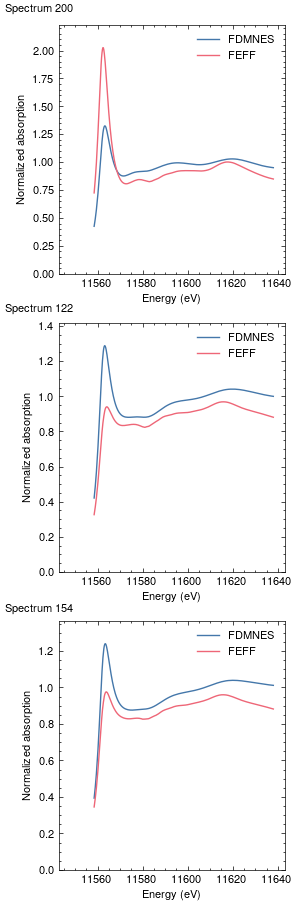

In [83]:
plot_spectra_and_CN_stack(spectra_and_CN, index_list)

In [17]:
def get_XAS_fdmnes(filename: str, w: int = 1) -> np.ndarray:
    """Reads the XAS data from a FDMNES output file

    Args:
        filename (str): FDMNES output file path
        w (int, optional): Weight of the XAS spectrum. Defaults to 1.

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """

    fdmnes_data = np.loadtxt(filename, skiprows=1)
    fdmnes_data[:, 0] += fdmnes_energy_shift
    fdmnes_data[:, 1] /= fdmnes_scale_factors*w
    return fdmnes_data

def get_XAS_feff(filename: str) -> np.ndarray:
    """Reads the XAS data from a FEFF output file

    Args:
        filename (str): FEFF output file path

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """
    feff_data = np.loadtxt(filename, skiprows=1)
    return feff_data[:, [0,3]]

def get_XAS_experiment(filename: str, i: int, dele: float = 0.0) -> np.ndarray:
    """Reads the XAS data from an experimental file

    Args:
        filename (str): Experimental file path
        i (int): Column index of the absorption coefficients
        dele (float, optional): Energy shift. Defaults to 0.0. The energy will be calculated as energy = energy - dele.

    Returns:
        XAS_spectrum(np.ndarray): XAS data. First column is the energy, second column is the normalized absorption coefficients.
    """
    experiment_data = np.loadtxt(filename, skiprows=1)
    experiment_data[:,0] -= dele
    return experiment_data[:, [0, i]]


def w(filename,n):
    """Obtain weight from the fdmnes output file

    Args:
        filename (str): FDMNES output file path
        n (int): Index of site

    Returns:
        weight (float): Multiplicity of the site
    """

    # n=0
    with open(filename,'r') as f:
        text = f.readlines()

    for line in text:
        if line.startswith("ipr"):
            if n == 0:
                return float(line.split()[-1])

            n-=1


In [18]:
from scipy.spatial import distance

NN_RANGE = [
    [0, 3.5],
    [3.5, 4.4],
    [4.4, 5.2],
    [5.2, 6.0],
]

# some efficient ways to calculate distance matrix
def dist_matrix(xyz: np.ndarray, absorb_index: int = None)->np.ndarray:
    """Calculate the distance matrix of the atoms

    Args:
        xyz (np.ndarray): Coordinates of the atoms
        absorb_index (int, optional): Index of the absorbing atom. Defaults to None.

    Returns:
        np.ndarray: Distance matrix of xyz coordinates. If absorb_index is None, the shape of the matrix is (N, N), where N is the number of atoms. If absorb_index is not None, the shape of the matrix is (1, N).
    """
    if absorb_index is None:
        return distance.cdist(xyz, xyz, "euclidean")
        # d = xyz[:,None,:]-xyz
        # return np.sqrt(np.einsum('ijk,ijk->ij',d,d))
    else:
        return distance.cdist(xyz[[absorb_index]], xyz, "euclidean")
        # d = xyz[absorb_index] - xyz
        # return np.sqrt(np.einsum('ij,ij->i',d,d))

def get_NN_from_xyz(xyz: np.ndarray, absorb_index:int = None, NN_range: list[list] = None):
    """Calculate the nearest neighbor distribution of the atoms

    Args:
        xyz (np.ndarray): Coordinates of the atoms
        absorb_index (int, optional): Index of the absorbing atom. Defaults to None.
        NN_range (list[list], optional): Range of the nearest neighbor distribution. Defaults to None.

    Returns:
        np.ndarray: Nearest neighbor distribution of the atoms. If absorb_index in None, particle average NN is returned. If absorb_index is not None, site specific NN is returned.
    """
    if NN_range is None:
        NN_range = NN_RANGE

    dist_mat = dist_matrix(xyz, absorb_index)

    if absorb_index is not None:
        atom_num = 1
    else:
        atom_num = len(xyz)

    NN = []

    for i in range(len(NN_range)):
        NN_tmp = dist_mat[(dist_mat > NN_range[i][0]) & (dist_mat <= NN_range[i][1])]
        NN.append(len(NN_tmp)/atom_num)

    return np.array(NN)



In [19]:
from glob import glob

def obtain_spectra_and_CN_single_site(dir_path: str, n: int = 0):
    """Obtain XAS spectra, coordination number and coordinates from a directory

    Args:
        dir_path (str): Directory path
        n (int, optional): Index of site. Defaults to 0.

    Returns:
        [fdmnes_data, feff_data, CN, file_xyz]: [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]
    """
    file_xyz = glob(os.path.join(dir_path, "*.xyz"))[0]
    feff_inp = os.path.join(dir_path, "feff.inp")
    feff_out = os.path.join(dir_path, "xmu.dat")
    fdmnes_file = os.path.join(dir_path, "out_fdmnes_conv.txt")
    fdmnes_bav_file = os.path.join(dir_path, "out_fdmnes_bav.txt")
    absorb_index, positions = read_xyz_from_feff_file(feff_inp)
    weight = w(fdmnes_bav_file, n)
    fdmnes_data = get_XAS_fdmnes(fdmnes_file, weight)
    feff_data = get_XAS_feff(feff_out)
    CN = get_NN_from_xyz(positions, absorb_index)
    return [fdmnes_data, feff_data, CN, file_xyz]

def obtain_spectra_and_CN(dir_path):
    """Obtain XAS spectra, coordination number and coordinates from a directory

    Args:
        dir_path (str): Directory path

    Returns:
        spectra_and_CN (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]
    """
    particle_name_pattern = re.compile(r'.*/(.+)/(.*)/')

    dir_list = glob(os.path.join(dir_path, "*/*/"))

    spectra_and_CN = []

    for directory in dir_list:
        particle_regex = re.findall(particle_name_pattern, directory)[0]
        particle = particle_regex[0]
        site = particle_regex[1]

        directory = os.path.join(dir_path, particle, site)

        spectra_and_CN.append(obtain_spectra_and_CN_single_site(directory, int(site) - 1))

    return spectra_and_CN

## Simple tests for the utility functions

In [15]:
# Test obtaining the weight from the fdmnes output file
weight=w("./IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCN028/1/out_fdmnes_bav.txt",6)
weight

1.0

In [16]:
# Test obtaining Nearest Neighbors from the xyz file
xyz = np.array([[0,0,0],[0,0,1],[0,0,2],[0,0,3],[0,0,4],[0,0,5]])
print("NN around atom 0:",get_NN_from_xyz(xyz, 0))
print("Average NN:", get_NN_from_xyz(xyz))

NN around atom 0: [3. 1. 1. 0.]
Average NN: [4.         0.66666667 0.33333333 0.        ]


In [17]:
# Test reading the xyz file from the feff input file
data_dir = "IV_Machine_learning_demo/NN-XANES-data/"
sample_dir = ""
feff_file = "feff_for_Pt_bulk.dat"
fdmnes_file = "fdmnes_for_Pt_bulk_conv.txt"
experimnet_file = "exp_xanes.nor"


absorb_index, positions=read_xyz_from_feff_file(os.path.join(data_dir, "./nanoparticles/COC013/2/feff.inp"))
print("Absorb index: ", absorb_index)
print("Coordination number of COC013: ", get_NN_from_xyz(positions,absorb_index))

Absorb index:  1
Coordination number of COC013:  [5. 2. 4. 1.]


## Ploting utility functions

In [18]:
def plot_XANES(spectra, labels, E0 = 11563, E_range = None):

    if E_range is None:
        E_range = [E0 -20, E0 + 80]


    fig, ax = plt.subplots(figsize=(3,3))

    # set enegy range for E
    E0 = 11563
    E_range = [E0 -20, E0 + 80]


    for i in range(len(spectra)):
        ax.plot(spectra[i][:, 0], spectra[i][:, 1], label=labels[i])

    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Normalized absorption")

    ax.set_xlim(E_range)

    ax.legend()

    fig.tight_layout(pad=0.5)

    fig.show()


In [19]:
def plot_spectra_and_CN(spectra_and_CN, index_list, E0 = 11563, E_range = None):

    E0 = 11563
    if E_range is None:
        E_range = [E0 -20, E0 + 80]

    fig, ax = plt.subplots(len(index_list), 2, figsize=(6, 3*(len(index_list))))
    ax = ax.flatten()

    for i in range(len(index_list)):
        fig.text(0, 1-i/len(index_list), f"Spectrum {index_list[i]}")

        ax[i*2 + 0].plot(spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1], label="FDMNES")
        ax[i*2 + 1].plot(spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1], label="FEFF")
        ax[i*2 + 0].plot(foilexperiment[:, 0], foilexperiment[:, 1], label="Pt Foil (Exp)")
        ax[i*2 + 1].plot(foilexperiment[:, 0], foilexperiment[:, 1], label="Pt Foil (Exp)")

        y_max = max(spectra_and_CN[i][0][:, 1].max(), spectra_and_CN[i][1][:, 1].max())

        for j in range(2):
            ax[i*2 + j].set_xlabel("Energy (eV)")
            ax[i*2 + j].set_ylabel("Normalized absorption")
            ax[i*2 + j].set_ylim(0, y_max*1.1)
            ax[i*2 + j].set_xlim(E_range)
            ax[i*2 + j].legend()


    fig.tight_layout(h_pad=1.5, w_pad=0.5)
    fig.show()

In [20]:
import py3Dmol

def plot_molecule(file_xyz):
    with open(file_xyz, "r") as f:
        xyz = f.read()

    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz, "xyz")
    view.setStyle({'sphere':{'scale': 0.4}, 'stick':{'scale': 0.2}})
    # view.setStyle({'sphere':{'scale': 0.4}})
    view.zoomTo()
    return view

def plot_spectra_and_CN_model(spectra_and_CN, index_list):
    for index in index_list:
        print("Spectrum ID:", index)
        print("Coordination numbers:", spectra_and_CN[index][2])
        print("File path:", spectra_and_CN[index][3])
        plot_molecule(spectra_and_CN[index][3]).show()

In [21]:
def plot_spectra_and_CN_stack(spectra_and_CN, index_list, E0 = 11563, E_range = None):

    E0 = 11563
    if E_range is None:
        E_range = [E0 -20, E0 + 80]

    fig, ax = plt.subplots(len(index_list), 1, figsize=(3, 3*(len(index_list))))
    ax = ax.flatten()

    for i in range(len(index_list)):
        fig.text(0, 1-i/len(index_list), f"Spectrum {index_list[i]}")

        ax[i].plot(spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1], label="FDMNES")
        ax[i].plot(spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1], label="FEFF")

        y_max = max(spectra_and_CN[i][0][:, 1].max(), spectra_and_CN[i][1][:, 1].max())

        ax[i].set_xlabel("Energy (eV)")
        ax[i].set_ylabel("Normalized absorption")
        ax[i].set_ylim(0, y_max*1.1)
        ax[i].set_xlim(E_range)
        ax[i].legend()

    fig.tight_layout(h_pad=1.5, w_pad=0.5)
    fig.show()

# 2. Loading Data

## Read foil spectra

In [22]:
foilFEFF = get_XAS_feff(os.path.join(data_dir, sample_dir, feff_file))
foilFDMNES = get_XAS_fdmnes(os.path.join(data_dir, sample_dir, fdmnes_file), 4)
foilexperiment = get_XAS_experiment(os.path.join(data_dir, sample_dir, experimnet_file), 1, 3)

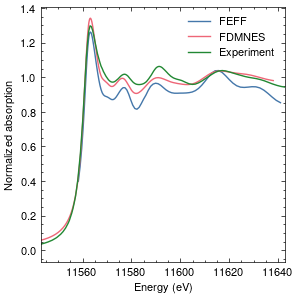

In [25]:
plot_XANES([foilFEFF, foilFDMNES, foilexperiment], ["FEFF", "FDMNES", "Experiment"])

## Read Theoretical XANES spectra

In [26]:
spectra_and_CN = obtain_spectra_and_CN(dir_path)

### Plot some random model and spectra

Spectrum ID: 132
Coordination numbers: [12.  6. 24. 12.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCO185/31/Pt185.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Spectrum ID: 108
Coordination numbers: [6. 2. 8. 3.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/TOC038/1/Pt38.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Spectrum ID: 150
Coordination numbers: [ 8.  5. 12.  8.]
File path: IV_Machine_learning_demo/NN-XANES-data/nanoparticles/HCO185/28/Pt185.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

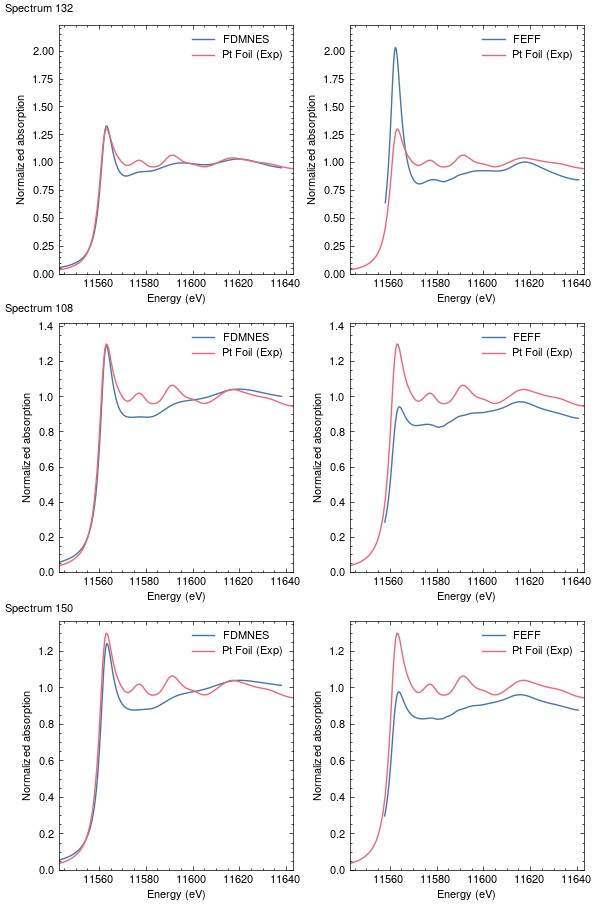

In [27]:
index_list = np.random.randint(0, len(spectra_and_CN), 3)

plot_spectra_and_CN_model(spectra_and_CN, index_list)
plot_spectra_and_CN(spectra_and_CN, index_list)

## Interpolate the spectra to the same energy grid

In [88]:
min_feff = np.min([spectra_and_CN[i][1][0][0] for i in range(len(spectra_and_CN))])
max_feff = np.min([spectra_and_CN[i][1][-1][0] for i in range(len(spectra_and_CN))])
min_fdmnes = np.max([spectra_and_CN[i][0][0][0] for i in range(len(spectra_and_CN))])
max_fdmnes = np.max([spectra_and_CN[i][0][-1][0] for i in range(len(spectra_and_CN))])

print(f"Energy range of FEFF: {min_feff} - {max_feff}")
print(f"Energy range of FDMNES: {min_fdmnes} - {max_fdmnes}")

Energy range of FEFF: 11557.844 - 11640.53
Energy range of FDMNES: 11543.0 - 11638.0


In [89]:
# caculate the energy range of the spectra, which contains all the spectra
emin = np.max([min_feff, min_fdmnes, foilFDMNES[0][0], foilFEFF[0][0]])
emax = np.min([max_feff, max_fdmnes, foilFDMNES[-1][0], foilFEFF[-1][0]])
emesharray = spectra_and_CN[0][0][:, 0]
emesh = emesharray[np.logical_and(emesharray<=emax, emesharray>=emin)]

/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/1192666718.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


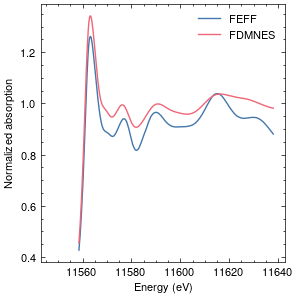

In [90]:
# interpolate the spectra to the same energy mesh (emesh)
foilFEFFi = np.interp(emesh, foilFEFF[:, 0], foilFEFF[:, 1])
foilFDMNESi = np.interp(emesh, foilFDMNES[:, 0], foilFDMNES[:, 1])

plot_XANES([np.array([emesh, foilFEFFi]).T, np.array([emesh, foilFDMNESi]).T], ["FEFF", "FDMNES"], E_range=[emin, emax])

In [91]:
# interpolate all of the spectra to same energy mesh
for i in range(len(spectra_and_CN)):
    spectra_and_CN[i][0] = np.stack([emesh, np.interp(emesh, spectra_and_CN[i][0][:, 0], spectra_and_CN[i][0][:, 1])]).T
    spectra_and_CN[i][1] = np.stack([emesh, np.interp(emesh, spectra_and_CN[i][1][:, 0], spectra_and_CN[i][1][:, 1])]).T


/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/589210078.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


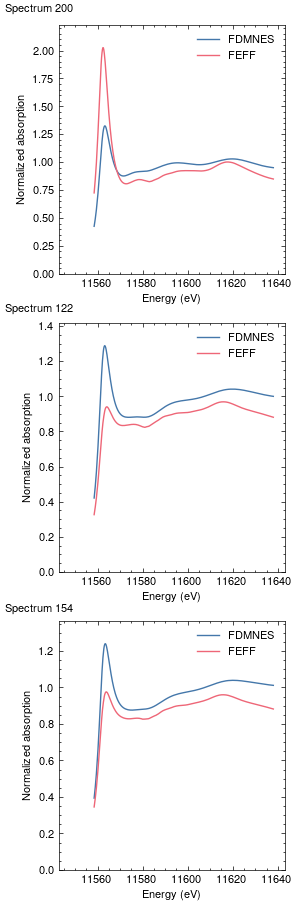

In [92]:
plot_spectra_and_CN_stack(spectra_and_CN, index_list)

# 3. Prepare Data for training
## Data augmentation
The data provided by the theoretical data is not enough to train the neural network. Therefore, we need to augment the data set by using a linear combination of the spectra and the coordination number. This is justified by the fact that XAS is a ensemble technique that spectra is a linear combination of the indvidual contrubutions of the atoms.

In [93]:
bulk_CNs = np.array([12, 6, 24, 12])

In [117]:
def linear_combination_FDMNES(n: int, spectra: list):
    """Calculate the averaged spectrum and averaged coordination number of n random FDMNES spectra

    Args:
        n (int): Number of spectra to calculate averaged spectrum
        spectra (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]

    Returns:
        spectra_ave (np.ndarray): Averaged spectrum
        coordinates_ave (np.ndarray): Averaged coordination number
    """
    num = np.random.randint(0, len(spectra), n)
    spectra_tmp = []
    coordinates_tmp = []

    for i in num:
        spectra_tmp.append(spectra[i][0][:, 1])
        coordinates_tmp.append(spectra[i][2])

    spectra_ave = np.mean(spectra_tmp, axis=0) - foilFDMNESi
    coordinates_ave = np.mean(coordinates_tmp, axis=0)/bulk_CNs

    return spectra_ave, coordinates_ave

def linear_combination_FEFF(n: int, spectra: list):
    """Calculate the averaged spectrum and averaged coordination number of n random FEFF spectra

    Args:
        n (int): Number of spectra to calculate averaged spectrum
        spe ctrum (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]

    Returns:
        spectra_ave (np.ndarray): Averaged spectrum
        coordinates_ave (np.ndarray): Averaged coordination number
    """
    num = np.random.randint(0, len(spectra), n)
    spectra_tmp = []
    coordinates_tmp = []

    for i in num:
        spectra_tmp.append(spectra[i][1][:, 1])
        coordinates_tmp.append(spectra[i][2])

    spectra_ave = np.mean(spectra_tmp, axis=0) - foilFEFFi
    coordinates_ave = np.mean(coordinates_tmp, axis=0)/bulk_CNs

    return spectra_ave, coordinates_ave

def gen_training_FDMNES(num: int, n: int, spectra: list):
    """Generate training data for FDMNES spectra

    Args:
        num (int): Number of training data to be generated
        n (int): Number of spectra to calculate averaged spectrum
        spectra (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]

    Returns:
        data_x (list): List of averaged spectra
        data_y (list): List of averaged coordination numbers
    """
    data_x = []
    data_y = []

    for i in range(num):
        data=linear_combination_FDMNES(n,spectra)
        data_x.append(data[0])
        data_y.append(data[1])
    return data_x,data_y

def gen_training_FEFF(num, n,spectrums):
    """Generate training data for FEFF spectra

    Args:
        num (int): Number of training data to be generated
        n (int): Number of spectra to calculate averaged spectrum
        spectra (list): List of [FDMNES XAS data, FEFF XAS data, coordination number, file path to coordinates]

    Returns:
        data_x (list): List of averaged spectra
        data_y (list): List of averaged coordination numbers
    """
    data_x = []
    data_y = []

    for i in range(num):
        data=linear_combination_FEFF(n,spectrums)
        data_x.append(data[0])
        data_y.append(data[1])
    return data_x,data_y


In [120]:
# Test generating training data

num = 10000
n = 3
data_x, data_y = gen_training_FDMNES(num, n, spectra_and_CN)

/var/folders/v9/ks1bt2jd7fq14x1k2xx9x7p40000gn/T/ipykernel_64815/406475189.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


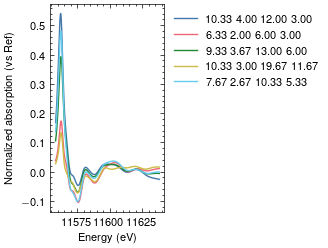

In [133]:
# Plot random 3 averaged spectra
index_list = np.random.randint(0, num, 5)

fig, ax = plt.subplots()

for i in index_list:
    ax.plot(emesh, data_x[i], label= "{:.2f} {:.2f} {:.2f} {:.2f}".format(*data_y[i]*bulk_CNs))

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Normalized absorption (vs Ref)")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
fig.tight_layout(pad=0.5)
fig.show()


# Next step: [Creating, training, and evaluation of a neural network](./03_NN_XANES_Neural_network.ipynb)